<a href="https://colab.research.google.com/github/J28-cmd/Proyecto-2.-CNN_Imag/blob/main/Proyecto%202.%20CNN_J.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_SIZE = (128, 128)
DATA_PATH = '/content/drive/MyDrive/Imagenes/Imagenes'
CSV_PATH = '/content/drive/MyDrive/idrid_labels.csv'

In [92]:

df = pd.read_csv(CSV_PATH)
df['image_filename'] = df['id_code'].astype(str) + '.jpg'
df['binary_class'] = (df['Risk of macular edema '] > 0).astype(int)

In [93]:
# Dividir en train/val/test según el nombre
is_test = df['id_code'].str.contains('test')
df_test = df[is_test]
df_trainval = df[~is_test]

In [94]:
# Función para cargar imágenes
def load_and_process_image(filename):
    path = os.path.join(DATA_PATH, filename)
    img = load_img(path, target_size=IMAGE_SIZE)
    return img_to_array(img) / 255.0 # normalización

In [95]:
X = np.array([load_and_process_image(fname) for fname in df_trainval['image_filename']])
y = df_trainval['binary_class'].values


In [96]:
X_test = np.array([load_and_process_image(fname) for fname in df_test['image_filename']])
y_test = df_test['binary_class'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# Transformación de imagenes
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [98]:
# Definir Modelo
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [111]:
# Entrenar modelo
early_stop=EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.7019 - loss: 0.5118 - val_accuracy: 0.7333 - val_loss: 0.4909
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 828ms/step - accuracy: 0.7903 - loss: 0.4286 - val_accuracy: 0.7467 - val_loss: 0.4727
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 540ms/step - accuracy: 0.7536 - loss: 0.4451 - val_accuracy: 0.7600 - val_loss: 0.4603
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 785ms/step - accuracy: 0.7820 - loss: 0.4412 - val_accuracy: 0.7600 - val_loss: 0.4586
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 621ms/step - accuracy: 0.8032 - loss: 0.3992 - val_accuracy: 0.7600 - val_loss: 0.4438
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 644ms/step - accuracy: 0.8012 - loss: 0.4045 - val_accuracy: 0.7733 - val_loss: 0.4323
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 608ms/step - accuracy: 0.7923 - loss: 0.4624 - val_accuracy: 0.7600 - val_loss: 0.4512
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 757ms/step - accuracy: 0.7919 - loss: 0.4665 - val_accuracy: 0

In [112]:
# Evaluar
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.7563 - loss: 0.4802
Test Accuracy: 76.25%


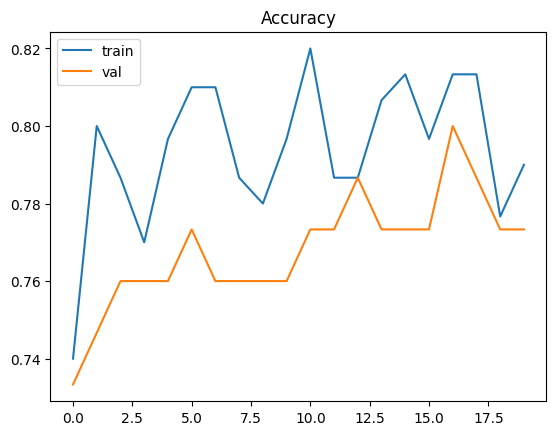

In [113]:
# Graficar entrenamiento
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [114]:
# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1) #informe de clasificación.

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 964ms/step


In [115]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.67      0.63        24
           1       0.85      0.80      0.83        56

    accuracy                           0.76        80
   macro avg       0.72      0.74      0.73        80
weighted avg       0.77      0.76      0.77        80



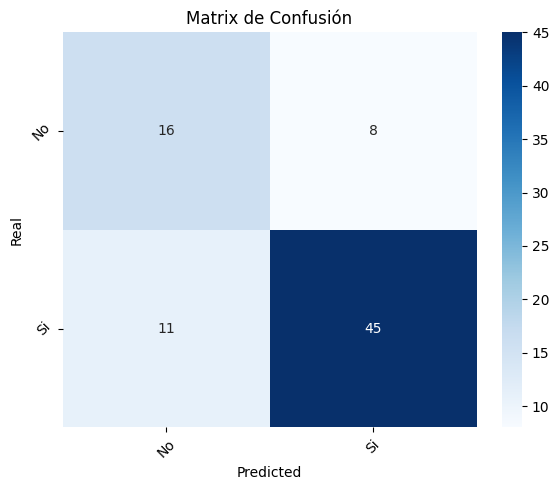

In [116]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Si"], yticklabels=["No", "Si"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matrix de Confusión')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [117]:
# Guardar modelo
model.save('idrid_cnn_model.h5')